In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [2]:
def get_channel_vocoder(s_win: int, offset: int, DAFx_in: np.ndarray, FS: int, nob: int):
    w = signal.windows.hann(s_win, sym=False)
    buf = DAFx_in[(offset - 1):(offset + s_win - 1)] * w
    f = np.fft.fft(buf) / (s_win / 2) 
    freq = np.arange(s_win) / s_win * FS
    flog = 20 * np.log10(0.00001 + np.abs(f))
    
    # frequency window
    w = signal.windows.hann(nob, sym=False)
    w1 = signal.windows.hann(nob, sym=False)
    w1 /= np.sum(w1)
    f_channel = np.pad(w1, (int((s_win - nob) / 2), int((s_win - nob) / 2)), 'constant')
    
    # FFT of frequency window
    fft_channel = np.fft.fft(np.fft.fftshift(f_channel))
    f2 = f * np.conj(f) # squared FFT values
    
    # circular convolution by FFT-Multiplication-IFFT
    energy = np.real(np.fft.ifft(np.fft.fft(f2) * fft_channel))
    flog_rms = 10 * np.log10(np.abs(energy))
    
    return freq, flog, flog_rms

In [3]:
def get_channel_vocoder_image(freq, flog, flog_rms, filename):
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    plt.plot(freq, flog)
    plt.plot(freq, flog_rms)
    plt.axis([0, 8000, -110, 0])
    plt.ylabel(r'$X(f)$/dB')
    plt.xlabel(r'$f$/Hz $\rightarrow$')
    plt.title('Short-time spectrum and spectral envelope')
    plt.tight_layout()
    plt.savefig(f"figures/{filename}.jpg", dpi=600, bbox_inches='tight')
    plt.show()

In [4]:
DAFx_in, FS = sf.read('input_audios/la.wav')
offset = 1000
s_win = 2048
nob = 64 # tem que ser par

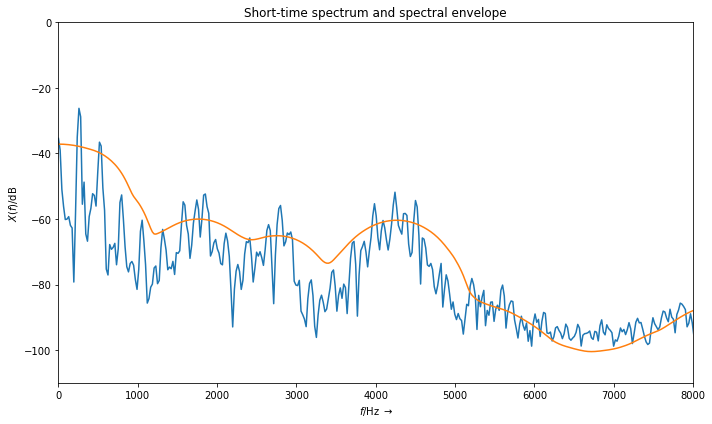

In [5]:
freq, flog, flog_rms = get_channel_vocoder(s_win, offset, DAFx_in, FS, nob)
get_channel_vocoder_image(freq, flog, flog_rms, f'ux_specenv_{s_win}_{offset}_{nob}')